In [1]:
import pandas as pd

In [2]:
#load demographics (which we will merge in to each vol table later
df_demog = (pd
            .read_table('resources/subjects_HCA.csv',sep=',')
            .assign(age = lambda df_: df_.interview_age/12.0)
            .assign(subject = lambda df_: 'sub-' + df_.subject.astype(str))            
           )

      
methods = ['freesurfer','ashs',
               'hippunfold-t2-freesurferatlas','hippunfold-t2-magdeburgatlas','hippunfold-t2-bigbrainatlas',
               'hippunfold-t1-freesurferatlas','hippunfold-t1-magdeburgatlas','hippunfold-t1-bigbrainatlas']
methods_abbr = ['FS','ASHS','HippUnfold-T2-FSatlas','HippUnfold-T2-ASHSatlas','HippUnfold-T2-BigBrainatlas',
                       'HippUnfold-T1-FSatlas','HippUnfold-T1-ASHSatlas','HippUnfold-T1-BigBrainatlas']

id_cols = ['subject','hemi','age','sex']

luts = {'freesurfer': 'resources/freesurfer_v21_CA_subfields_dseg.tsv',
        'ashs': 'resources/desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t1-freesurferatlas': 'resources/hippunfold_desc-subfields_atlas-freesurfer_dseg.tsv',
        'hippunfold-t1-magdeburgatlas': 'resources/hippunfold_desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t1-bigbrainatlas': 'resources/hippunfold_desc-subfields_atlas-bigbrain_dseg.tsv',
        'hippunfold-t2-freesurferatlas': 'resources/hippunfold_desc-subfields_atlas-freesurfer_dseg.tsv',
        'hippunfold-t2-magdeburgatlas': 'resources/hippunfold_desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t2-bigbrainatlas': 'resources/hippunfold_desc-subfields_atlas-bigbrain_dseg.tsv'}
               
all_subfields = { method: pd.read_table(luts[method]).abbreviation.to_list() for method in methods }



    
df = pd.concat( [(pd
            .read_table(f'results/{method}_volumes.tsv') #read table
            .merge(df_demog,on='subject')  # merge in demographics
            .melt(id_vars=id_cols,value_vars=all_subfields[method],var_name='subfield',value_name='volume')  #convert from wide to tidy
            .assign(method = lambda df_:abbr)  #add a column for the method
           )
            for method,abbr in zip(methods,methods_abbr) ]   #concatenate all the tidy tables 
         )

    
df = df.reset_index()

df.sample(20)
    
    

,index,subject,hemi,age,sex,subfield,volume,method
2819,103,sub-9548396,R,44.916667,M,ParaSub,0.152588,HippUnfold-T2-FSatlas
8507,941,sub-7268178,R,67.750000,F,CA3,154.992567,HippUnfold-T1-FSatlas
10482,1170,sub-9578406,L,36.750000,M,SRLM,682.341752,HippUnfold-T1-ASHSatlas
4733,271,sub-9157179,R,40.000000,M,CA2,65.898972,HippUnfold-T2-ASHSatlas
5415,953,sub-7530670,R,38.500000,M,Tail,386.042520,HippUnfold-T2-ASHSatlas
3990,1274,sub-7607477,L,81.083333,F,Tail,190.052930,HippUnfold-T2-FSatlas
699,699,sub-7195884,R,57.833333,M,CA1,837.752420,FS
1407,49,sub-6405157,R,77.916667,M,CA1,648.803014,ASHS
7120,1106,sub-7137567,L,45.916667,M,DG,135.283668,HippUnfold-T2-BigBrainatlas
9966,654,sub-6937998,L,63.416667,F,CA3,184.536933,HippUnfold-T1-ASHSatlas


## Bland-altman plots

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def plot_bland_altman(df,methods1,methods2,subfields,figsize=(18,16)):

    f, axs = plt.subplots(ncols=len(methods1),nrows=len(subfields), figsize=figsize, squeeze=False)


    for i,(method1,method2) in enumerate(zip(methods1,methods2)):
        for j,subfield in enumerate(subfields):

            m1 = (df
                  .query(f'subfield == "{subfield}" and method == "{method1}"')
                  .volume
                  .to_numpy()
                 )
            m2 = (df
                  .query(f'subfield == "{subfield}" and method == "{method2}"')
                  .volume
                 .to_numpy()
                 )    
            
            sm.graphics.mean_diff_plot(m1,m2,ax=axs[j][i])


    #add column and row labels:

    rows = subfields
    cols = [f'{method1} vs {method2}' for method1,method2 in zip(methods1,methods2) ]


    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size='xx-large')

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='xx-large')

    if len(cols)>1:
        for j in range(1,len(cols)):
            for ax in axs[:,j]:
                ax.set_ylabel('')


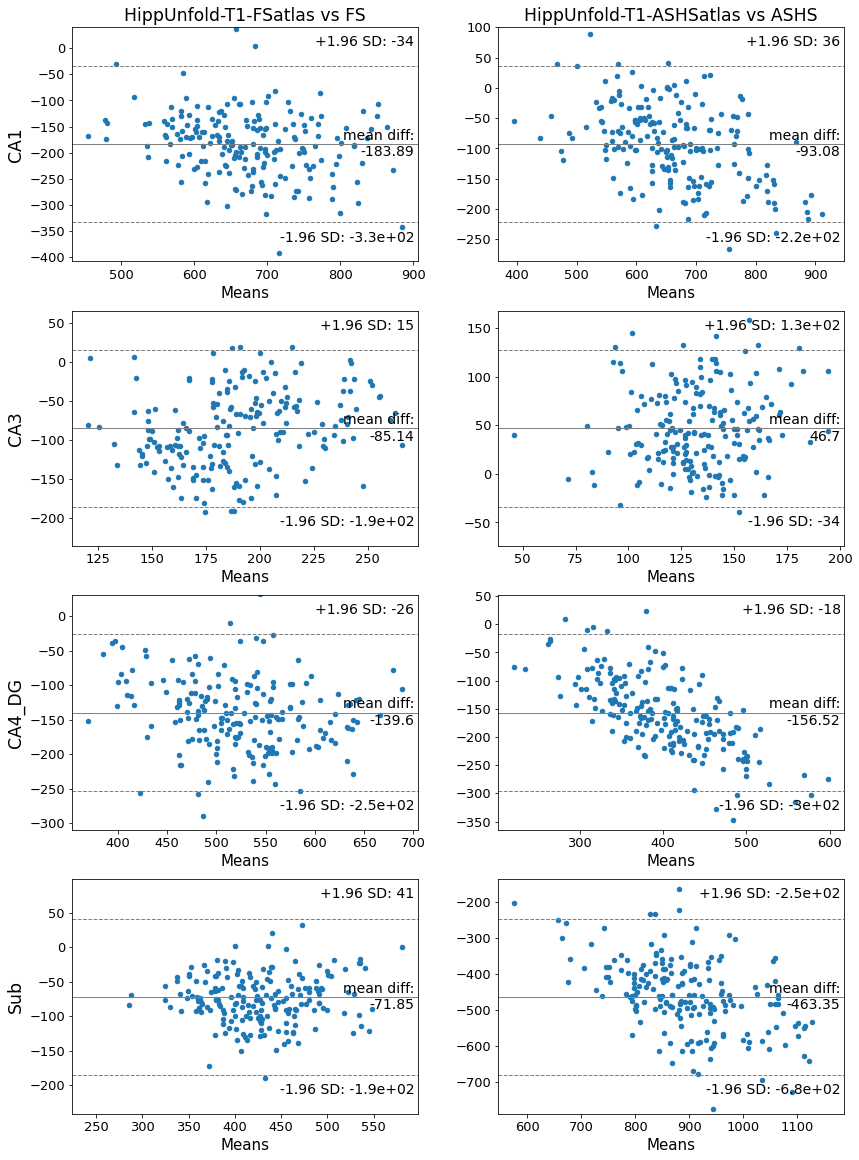

In [4]:
#compare hippunfold (T1) with FS and ASHS (using corresponding hippunfold atlases)

subfields = ['CA1','CA3','CA4_DG','Sub']

methods1 = ['HippUnfold-T1-FSatlas','HippUnfold-T1-ASHSatlas']
methods2 = ['FS','ASHS']
plot_bland_altman(df,methods1,methods2,subfields,figsize=(12,16))

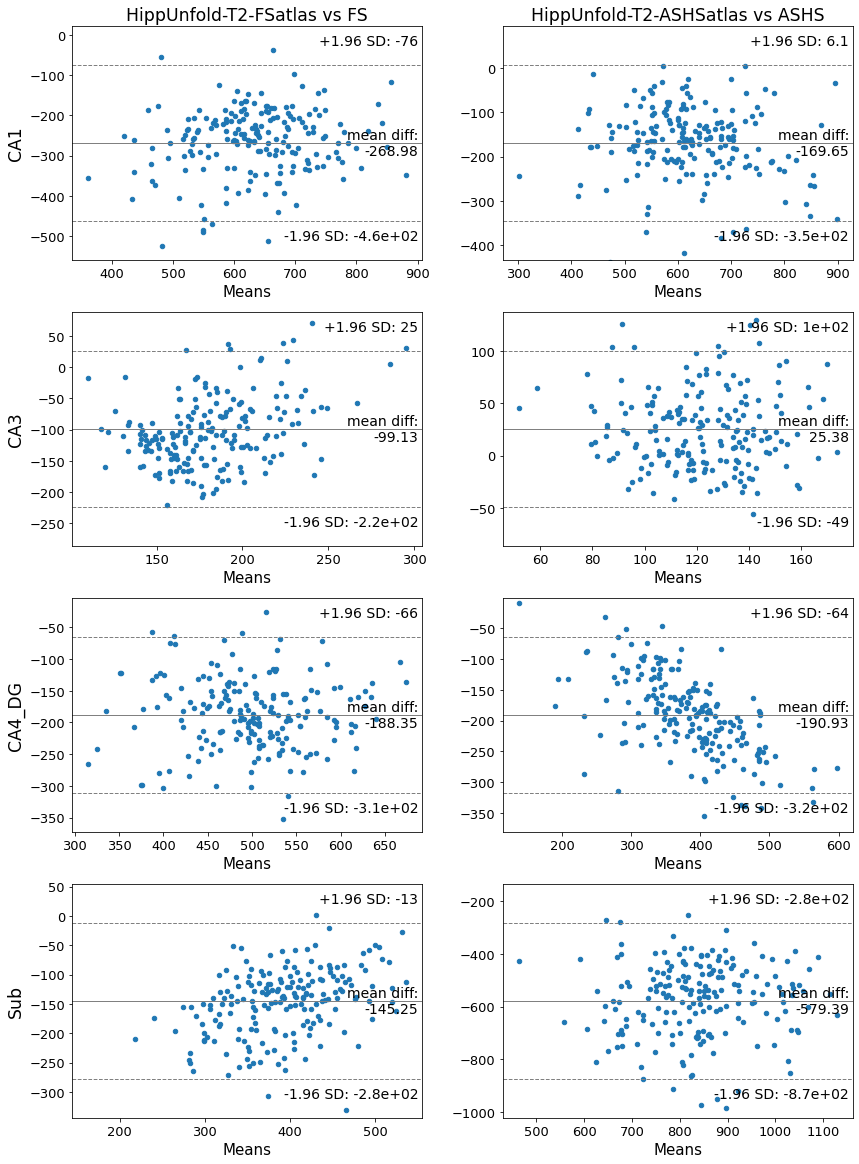

In [5]:
#compare hippunfold (T2) with FS and ASHS (using corresponding hippunfold atlases)

subfields = ['CA1','CA3','CA4_DG','Sub']

methods1 = ['HippUnfold-T2-FSatlas','HippUnfold-T2-ASHSatlas']
methods2 = ['FS','ASHS']
plot_bland_altman(df,methods1,methods2,subfields,figsize=(12,16))

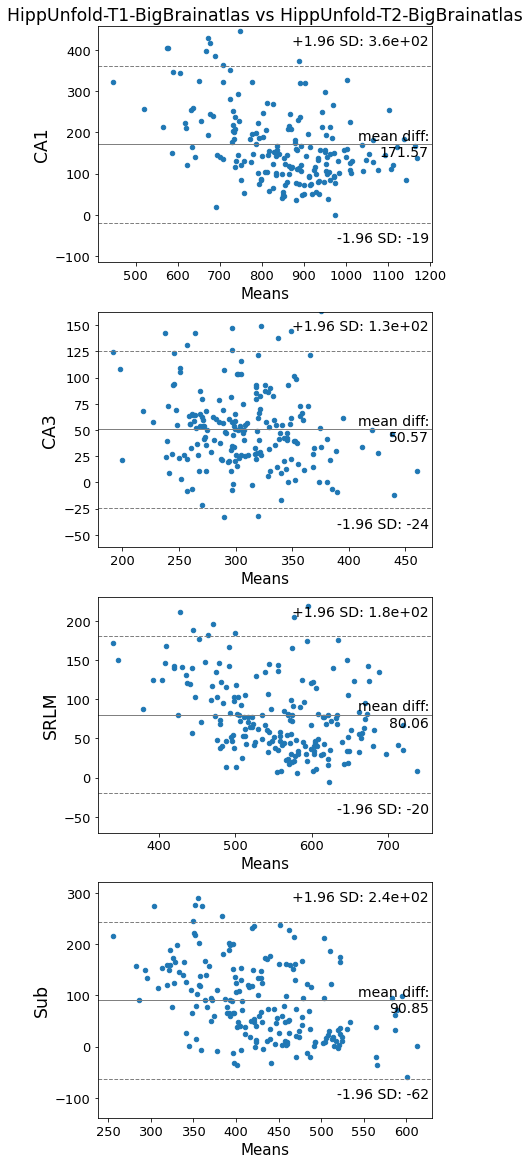

In [6]:
#comparing T1w and T2w (TSE) hippunfold

subfields = ['CA1','CA3','SRLM','Sub']

methods1 = ['HippUnfold-T1-BigBrainatlas']
methods2 = ['HippUnfold-T2-BigBrainatlas']
plot_bland_altman(df,methods1,methods2,subfields,figsize=(6,16))

## Vol vs Age plots

In [7]:
import seaborn as sns


def plot_scatter(df,methods1,methods2,subfields,figsize=(30,15)):


    f, axs = plt.subplots(ncols=len(methods1),nrows=len(subfields), figsize=figsize,squeeze=False)


    for i,(method1,method2) in enumerate(zip(methods1,methods2)):
        for j,subfield in enumerate(subfields):

            sns.regplot(data=(df
                    .query(f'subfield == "{subfield}" and method == "{method1}"')
                             )
                            ,x='age',y='volume',ax=axs[j][i],label=method1)
            sns.regplot(data=(df
                    .query(f'subfield == "{subfield}" and method == "{method2}"')
                             )
                            ,x='age',y='volume',ax=axs[j][i],label=method2)        

            axs[j,i].legend()

    #add column and row labels:

    rows = subfields
    cols = [f'{method1} vs {method2}' for method1,method2 in zip(methods1,methods2) ]


    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size='xx-large')

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='xx-large')

    if len(cols)>1:
        for j in range(1,len(cols)):
            for ax in axs[:,j]:
                ax.set_ylabel('')

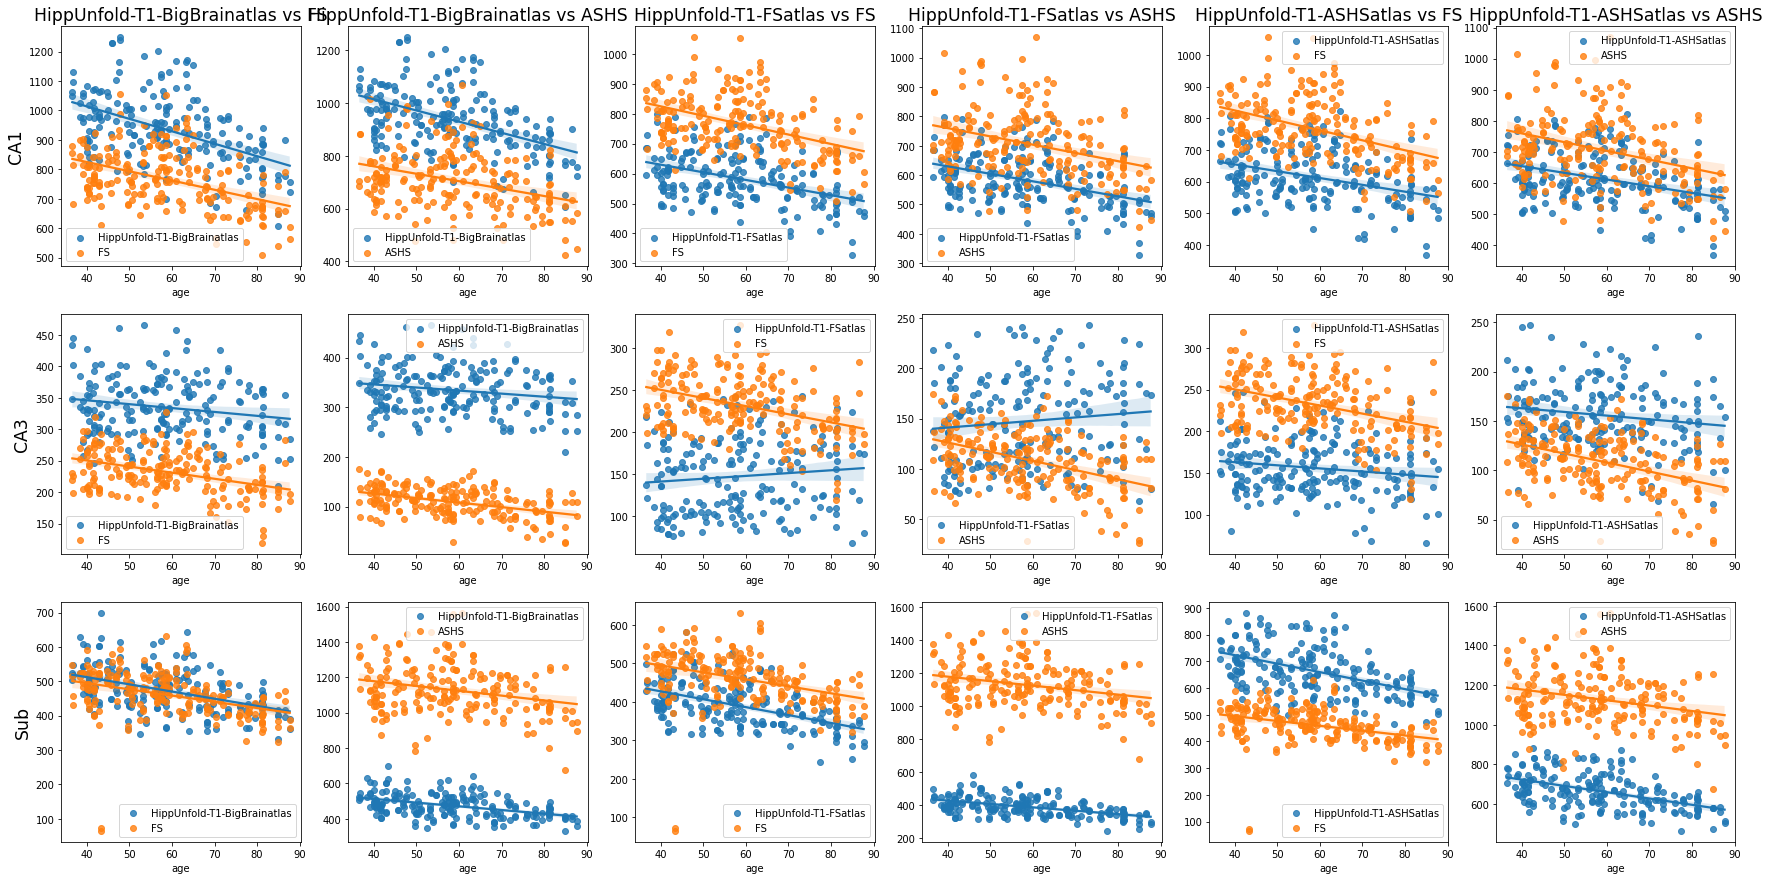

In [8]:
#compare hippunfold run on T1w (and various atlases) with FS and ASHS

methods1 = ['HippUnfold-T1-BigBrainatlas','HippUnfold-T1-BigBrainatlas','HippUnfold-T1-FSatlas','HippUnfold-T1-FSatlas','HippUnfold-T1-ASHSatlas','HippUnfold-T1-ASHSatlas']
methods2 = ['FS','ASHS','FS','ASHS','FS','ASHS']
subfields = ['CA1','CA3','Sub']

plot_scatter(df,methods1,methods2,subfields)

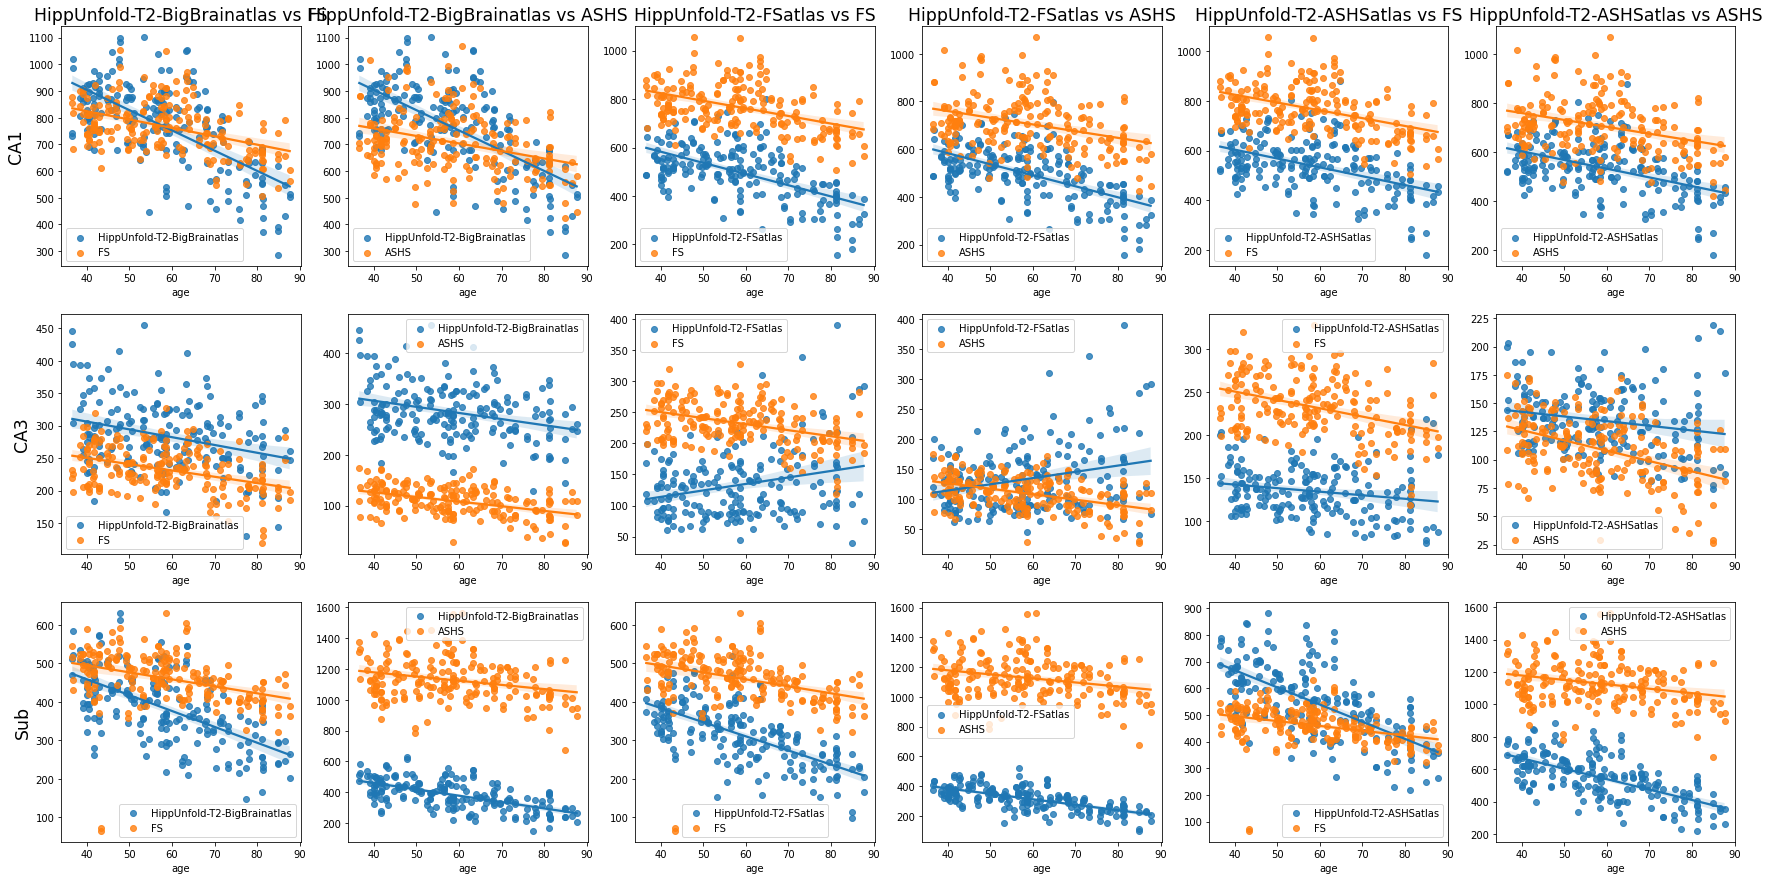

In [9]:
import seaborn as sns

#compare hippunfold run on T2 TSE (and various atlases) with FS and ASHS

methods1 = ['HippUnfold-T2-BigBrainatlas','HippUnfold-T2-BigBrainatlas','HippUnfold-T2-FSatlas','HippUnfold-T2-FSatlas','HippUnfold-T2-ASHSatlas','HippUnfold-T2-ASHSatlas']
methods2 = ['FS','ASHS','FS','ASHS','FS','ASHS']
subfields = ['CA1','CA3','Sub']


plot_scatter(df,methods1,methods2,subfields)

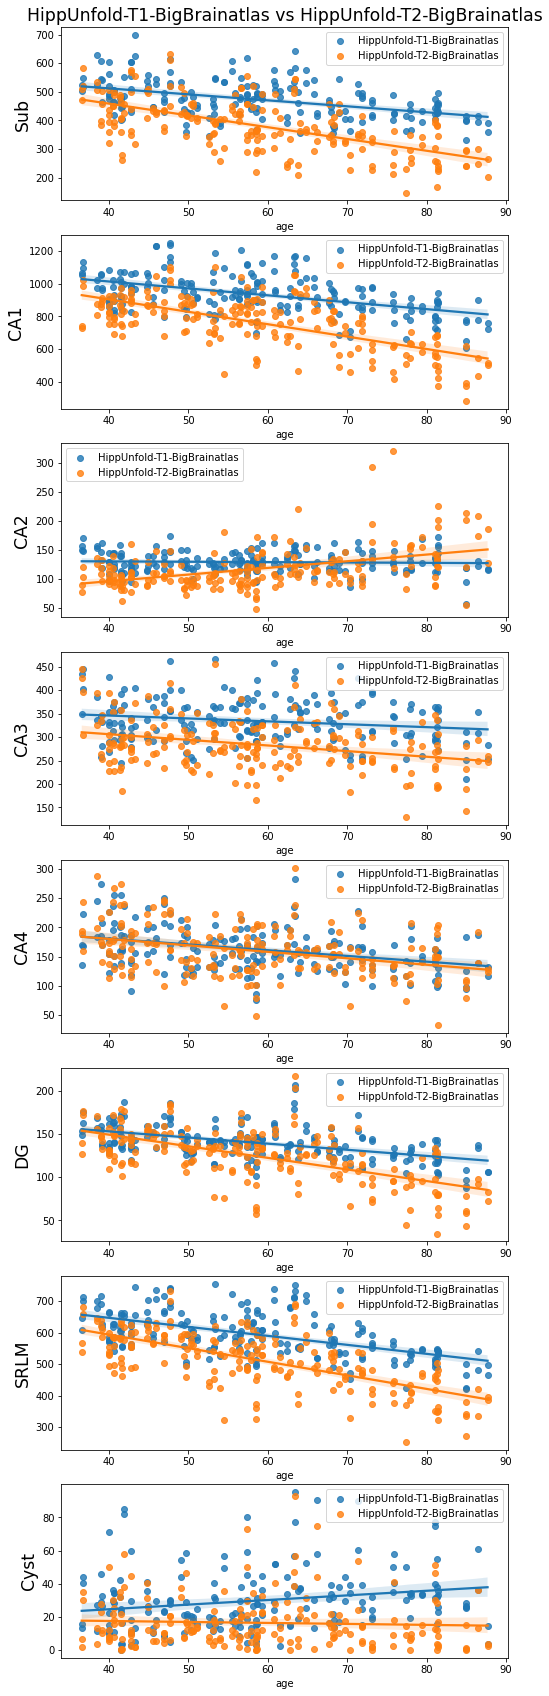

In [10]:

#compare hippunfold run on T2 TSE  with T1w for all subfield labels


methods1 = ['HippUnfold-T1-BigBrainatlas'] 
methods2 = ['HippUnfold-T2-BigBrainatlas']

subfields = all_subfields['hippunfold-t1-bigbrainatlas']


plot_scatter(df,methods1,methods2,subfields,figsize=(8,30))

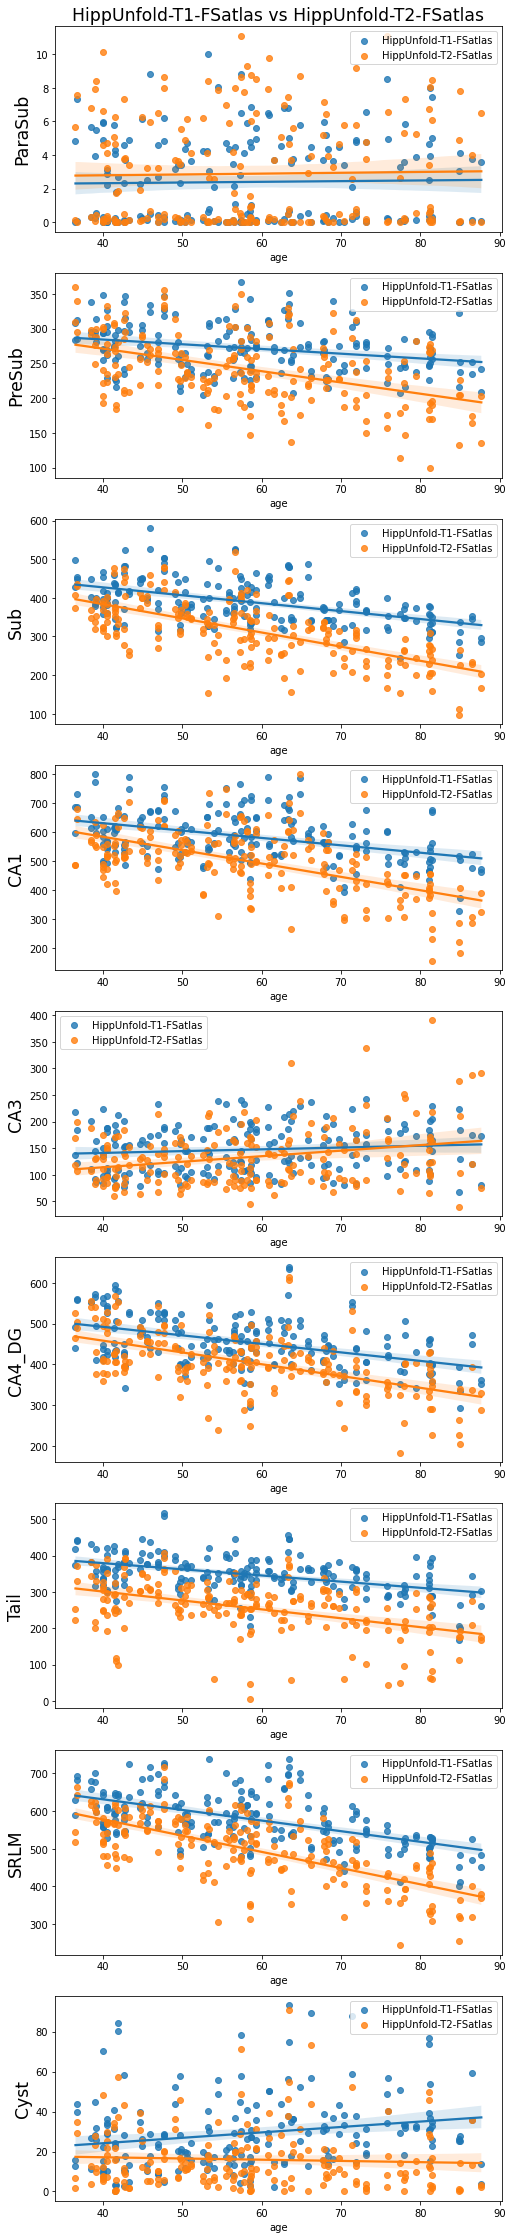

In [11]:
#compare hippunfold run on T2 TSE  with T1w for all subfield labels


methods1 = ['HippUnfold-T1-FSatlas'] 
methods2 = ['HippUnfold-T2-FSatlas']

subfields = all_subfields['hippunfold-t1-freesurferatlas']


plot_scatter(df,methods1,methods2,subfields,figsize=(8,40))

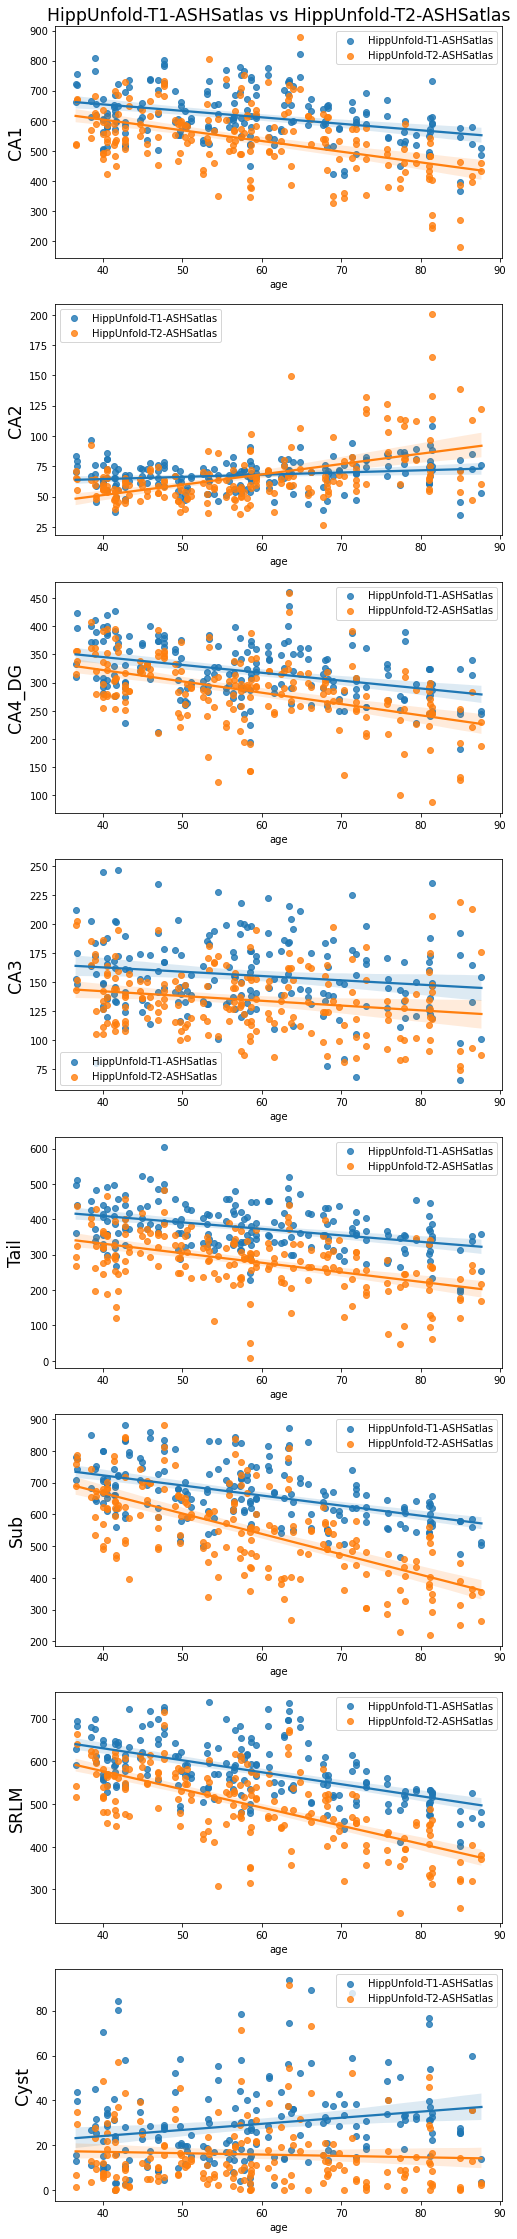

In [12]:
#compare hippunfold run on T2 TSE  with T1w for all subfield labels


methods1 = ['HippUnfold-T1-ASHSatlas'] 
methods2 = ['HippUnfold-T2-ASHSatlas']

subfields = all_subfields['hippunfold-t1-magdeburgatlas']


plot_scatter(df,methods1,methods2,subfields,figsize=(8,40))